# Assignment02. Bigger data and communications

## Load the NYC 311 Data as a JSON API

In [3]:
# To ignore unimporant system warnings
import warnings
warnings.filterwarnings("ignore")

# We will use Pandas, Numpy, and Matplotlib which is a package for visualization with Python
import pandas as pd
import numpy as np

# Load a required package 
# This is a library for accessing and parsing data through URLs
from urllib.parse import urlencode
import urllib.request, json 
from bs4 import BeautifulSoup # for web scraping
import fiona
import plotly.express as px
import geopandas as gpd
import seaborn as sns # visualization styling package


# A magic functin that renders the figure in a notebook 
%matplotlib inline 

In [ ]:
API = 'https://data.cityofnewyork.us/resource/erm2-nwe9.csv?'
# https://data.cityofnewyork.us/resource/erm2-nwe9.json

## Query the Noise Data

In [ ]:
query = {'$select': 'created_date, complaint_type, resolution_description, incident_zip, borough, latitude, longitude',
         '$where': 'complaint_type="Noise" OR complaint_type="Noise - Residential" OR complaint_type="Noise - Street/Sidewalk" OR complaint_type="Noise - Vehicle" OR complaint_type="Noise - Commercial" OR complaint_type="Noise - Park" OR complaint_type="Noise - House of Worship" AND status="Closed"',
         '$order': 'created_date',
         '$limit': 300000000} 

df = pd.read_csv(API + urlencode(query),
                 parse_dates = ['created_date'],
                 dtype = {'incident_zip':'str'})
df.head()

,created_date,complaint_type,resolution_description,incident_zip,borough,latitude,longitude
0,2010-01-01 00:03:46,Noise - Residential,The Police Department responded to the complai...,11230,BROOKLYN,40.612155,-73.955036
1,2010-01-01 00:08:02,Noise - Residential,The Police Department responded to the complai...,11220,BROOKLYN,40.635708,-74.006853
2,2010-01-01 00:08:29,Noise - Residential,The Police Department responded to the complai...,10036,MANHATTAN,40.759486,-73.989135
3,2010-01-01 00:08:30,Noise - Residential,The Police Department responded to the complai...,10303,STATEN ISLAND,40.634762,-74.169727
4,2010-01-01 00:15:08,Noise - Residential,The Police Department responded to the complai...,11355,QUEENS,40.755060,-73.832251


## Convert the JSON data to Pandas DataFrame

In [ ]:
df.shape[0]

4802218

In [ ]:
df.dtypes

created_date              datetime64[ns]
complaint_type                    object
resolution_description            object
incident_zip                      object
borough                           object
latitude                         float64
longitude                        float64
dtype: object

In [ ]:
df = df.rename(columns={"created_date": "Date", "complaint_type": "Complaint", "resolution_description":"Resolution", "incident_zip": "Zipcode", "borough":"Borough"})
df["Complaint"] = df["Complaint"].str.replace("Noise -", "")
df.head()

,Date,Complaint,Resolution,Zipcode,Borough,latitude,longitude
0,2010-01-01 00:03:46,Residential,The Police Department responded to the complai...,11230,BROOKLYN,40.612155,-73.955036
1,2010-01-01 00:08:02,Residential,The Police Department responded to the complai...,11220,BROOKLYN,40.635708,-74.006853
2,2010-01-01 00:08:29,Residential,The Police Department responded to the complai...,10036,MANHATTAN,40.759486,-73.989135
3,2010-01-01 00:08:30,Residential,The Police Department responded to the complai...,10303,STATEN ISLAND,40.634762,-74.169727
4,2010-01-01 00:15:08,Residential,The Police Department responded to the complai...,11355,QUEENS,40.755060,-73.832251


## Drop Empty Values

In [ ]:
df.Borough.unique()

array(['BROOKLYN', 'MANHATTAN', 'STATEN ISLAND', 'QUEENS', 'BRONX',
       'Unspecified', nan], dtype=object)

In [ ]:
df.Zipcode.unique()

array(['11230', '11220', '10036', '10303', '11355', '10014', '10453',
       '10011', '10473', '11218', '11215', '10463', '10310', '11233',
       '10301', '11219', '11434', '11234', '10025', '11209', '10466',
       '11203', '10451', '10023', '11373', '11377', '10304', '10029',
       '11206', '11354', '11372', '11375', '11369', '10459', '10013',
       '10312', '11208', '11211', '11231', '11221', '10028', '10452',
       '10454', '11374', '10458', '11420', '10306', '10003', '10027',
       '10031', '10456', '11224', '11201', '11415', '10032', '11238',
       '11358', '11104', '10033', '11217', '11421', '10035', '10019',
       '10460', '11210', '10075', '11385', '11226', '11213', '11207',
       '11426', '11225', '11212', '10034', '10001', '11106', '10030',
       '10472', '11435', '11368', '10462', '11102', '11691', '10002',
       '11222', '10467', '10040', '10455', '11223', '10302', '11236',
       '10469', '11423', '10009', '10457', '11204', '10012', '11694',
       '11237', '112

In [ ]:
df['Borough'].replace('', np.nan, inplace=True)
df['Borough'].replace('Unspecified', np.nan, inplace=True)
df.dropna(subset=['Borough'], inplace=True)

In [ ]:
df['Zipcode'].replace('', np.nan, inplace=True)
df.dropna(subset=['Zipcode'], inplace=True)

In [ ]:
df.shape[0]

4789704

## View the Number of Complaints by Zipcode

In [ ]:
complaints_by_zip = df['Zipcode'].value_counts().to_frame('nc_freq')
complaints_by_zip = pd.DataFrame(complaints_by_zip).reset_index()
complaints_by_zip.columns = ['ZIPCODE', 'Complaint_Count']
complaints_by_zip.head()

,ZIPCODE,Complaint_Count
0,10466,141795
1,10031,90140
2,11226,88550
3,10032,82163
4,10034,78926


## Read Zipcode Geometry Shapefile as GeoDataFrame

In [4]:
gdf = gpd.read_file("/content/drive/MyDrive/GSAPP/1 Fall 21/Urban Informatics/Assignments/2/ZIP_CODE_040114", driver = "shapefile")
gdf.head()

DriverError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
gdf.dtypes

ZIPCODE         object
BLDGZIP         object
PO_NAME         object
POPULATION     float64
AREA           float64
STATE           object
COUNTY          object
ST_FIPS         object
CTY_FIPS        object
URL             object
SHAPE_AREA     float64
SHAPE_LEN      float64
geometry      geometry
dtype: object

In [ ]:
gdf = gdf.merge(complaints_by_zip, on ='ZIPCODE')
gdf.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,Complaint_Count
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.252 188138.380, 1038141.936 ...",8765
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.713 186926.440, 1002314.243 ...",44971
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.276 183696.338, 1011373.584 ...",38492
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.365 183617.613, 996522.848 18...",53069
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.113 176307.496, 992042.798 17...",24623


In [ ]:
print(gdf['Complaint_Count'].max())
print(gdf['Complaint_Count'].min())

141795
1


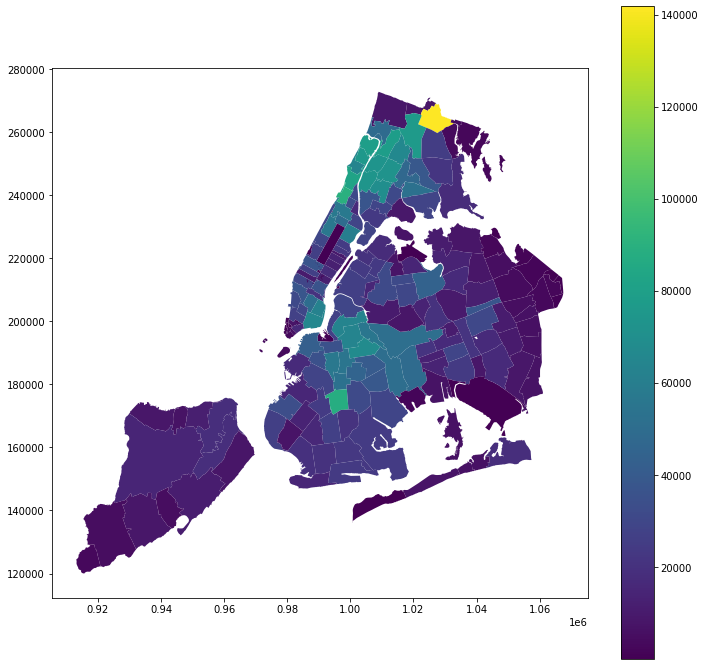

In [ ]:
gdf.plot("Complaint_Count", legend=True, figsize = (12,12))